In [1]:
from torchvision.datasets import MNIST
from torchvision import models
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import Adam
from torchvision.transforms import ToTensor
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
# Load MNIST dataset
MNIST_DATA_TRAIN = MNIST('../temp', download=True, train=True, transform=ToTensor())
MNIST_DATA_VALIDATION = MNIST('../temp', download=True, train=False, transform=ToTensor())

In [3]:
# Create Dataloaders from MNIST data
data_loader_train = DataLoader(MNIST_DATA_TRAIN,
                               batch_size=32,
                               shuffle=True)
data_loader_validation = DataLoader(MNIST_DATA_VALIDATION,
                                    batch_size=32,
                                    shuffle=True)

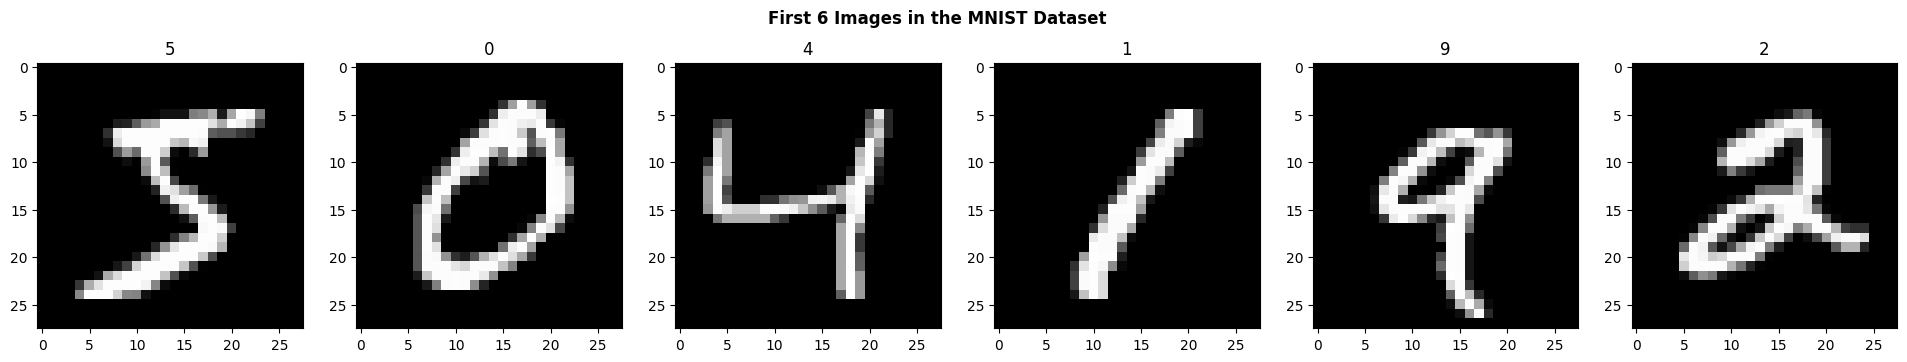

In [4]:
# View the first 6 images in the MNIST dataset
fig, ax = plt.subplots(1, 6, figsize=(24,12))
fig.suptitle('First 6 Images in the MNIST Dataset', y=0.65, fontweight='bold')
for i in range(6):
    ax[i].imshow(MNIST_DATA_TRAIN.data[i], cmap='gray')
    ax[i].set_title(MNIST_DATA_TRAIN.targets[i].item())
plt.show()

In [90]:
# Create CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm2d(num_features=16),
                                   nn.Dropout2d(p=0.4),
                                   nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm2d(num_features=32),
                                   nn.Dropout2d(p=0.4),
                                   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm2d(num_features=64),
                                   nn.Dropout2d(p=0.4),
                                   nn.Flatten(),
                                   nn.Dropout2d(p=0.4),
                                   nn.Linear(64*28*28, 10))

    def forward(self,x):
        return self.model(x)


In [91]:
# Instantiate model and choose loss function with optimizer
model = CNN().cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0015)

In [92]:
def train(epochs=10, validation_interval=10) -> list:
    """
    Training loop:
        Trains the CNN on the MNIST dataset for digit recognition

    Arguments:
        Epochs: Number of iterations to run through the dataset
        Learning Rate: Value to apply for the rate that the network learns
        Validation Interval: Interval for getting validation set metrics
    """

    # Create metric bins for evaluation
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    # Iterate through each epoch
    for epoch in range(epochs):

        # Instantiate progress bar loop
        loop = tqdm(total=len(data_loader_train), position=0, colour='green')

        # Iterate through each batch -> batch size of 32 images each
        for batch, (X_train, y_train) in enumerate(data_loader_train):

            # Create training set data and target partition and put them on the GPU
            X_train, y_train = X_train.cuda(), y_train.cuda()
            y_hat = model(X_train)

            # Zero out the gradients and computer backpropogation
            optimizer.zero_grad()
            loss = loss_fn(y_hat, y_train)
            loss.backward()

            # Calculate accuracy and append values to respective bins
            training_loss.append(loss.item())
            train_accuracy = (y_hat.argmax(1) == y_train).cpu().float().mean().item()
            training_accuracy.append(train_accuracy)

            # Set progress bar loop
            loop.set_description('Epoch: {} Batch: {} Loss: {} Accuracy: {}'.format(epoch, batch, loss.item(), train_accuracy))
            loop.update(1)
            optimizer.step()

            # Run validation loop to track network progress
            if batch % validation_interval == 0:
                validation_losses = []
                validation_sum = 0
                for validation_batch, (X_test, y_test) in enumerate(data_loader_validation):
                    X_test, y_test = X_test.cuda(), y_test.cuda()
                    y_hat = model(X_test)
                    validation_losses.append(loss_fn(y_hat, y_test).item())
                    validation_sum += (y_hat.argmax(dim=1) == y_test).cpu().float().mean()
                validation_loss.append((len(training_loss), np.array(validation_losses).mean()))
                validation_accuracy.append((len(training_loss), (validation_sum / len(data_loader_validation))))

    return training_loss, training_accuracy, validation_loss, validation_accuracy


In [94]:
training_loss, training_accuracy, validation_loss, validation_accuracy = train(epochs=10, validation_interval=200)

Epoch: 0 Batch: 1874 Loss: 1.7231276035308838 Accuracy: 0.8125: 100%|██████████| 1875/1875 [00:40<00:00, 46.62it/s]
Epoch: 1 Batch: 1874 Loss: 0.010708946734666824 Accuracy: 1.0: 100%|██████████| 1875/1875 [00:39<00:00, 47.95it/s]
Epoch: 2 Batch: 1874 Loss: 0.0829908698797226 Accuracy: 0.96875: 100%|██████████| 1875/1875 [00:39<00:00, 47.92it/s]
Epoch: 3 Batch: 1874 Loss: 0.12667781114578247 Accuracy: 0.96875: 100%|██████████| 1875/1875 [00:39<00:00, 47.19it/s]
Epoch: 4 Batch: 1874 Loss: 0.06282813847064972 Accuracy: 0.96875: 100%|██████████| 1875/1875 [00:39<00:00, 47.77it/s]
Epoch: 5 Batch: 1874 Loss: 0.08900066465139389 Accuracy: 0.9375: 100%|██████████| 1875/1875 [00:39<00:00, 47.99it/s]
Epoch: 6 Batch: 1874 Loss: 0.6237456202507019 Accuracy: 0.875: 100%|██████████| 1875/1875 [00:39<00:00, 46.95it/s]
Epoch: 7 Batch: 1874 Loss: 0.022536564618349075 Accuracy: 1.0: 100%|██████████| 1875/1875 [00:39<00:00, 47.93it/s]
Epoch: 8 Batch: 1874 Loss: 0.012416811659932137 Accuracy: 1.0: 100%|█

  0%|          | 0/1875 [07:11<?, ?it/s]


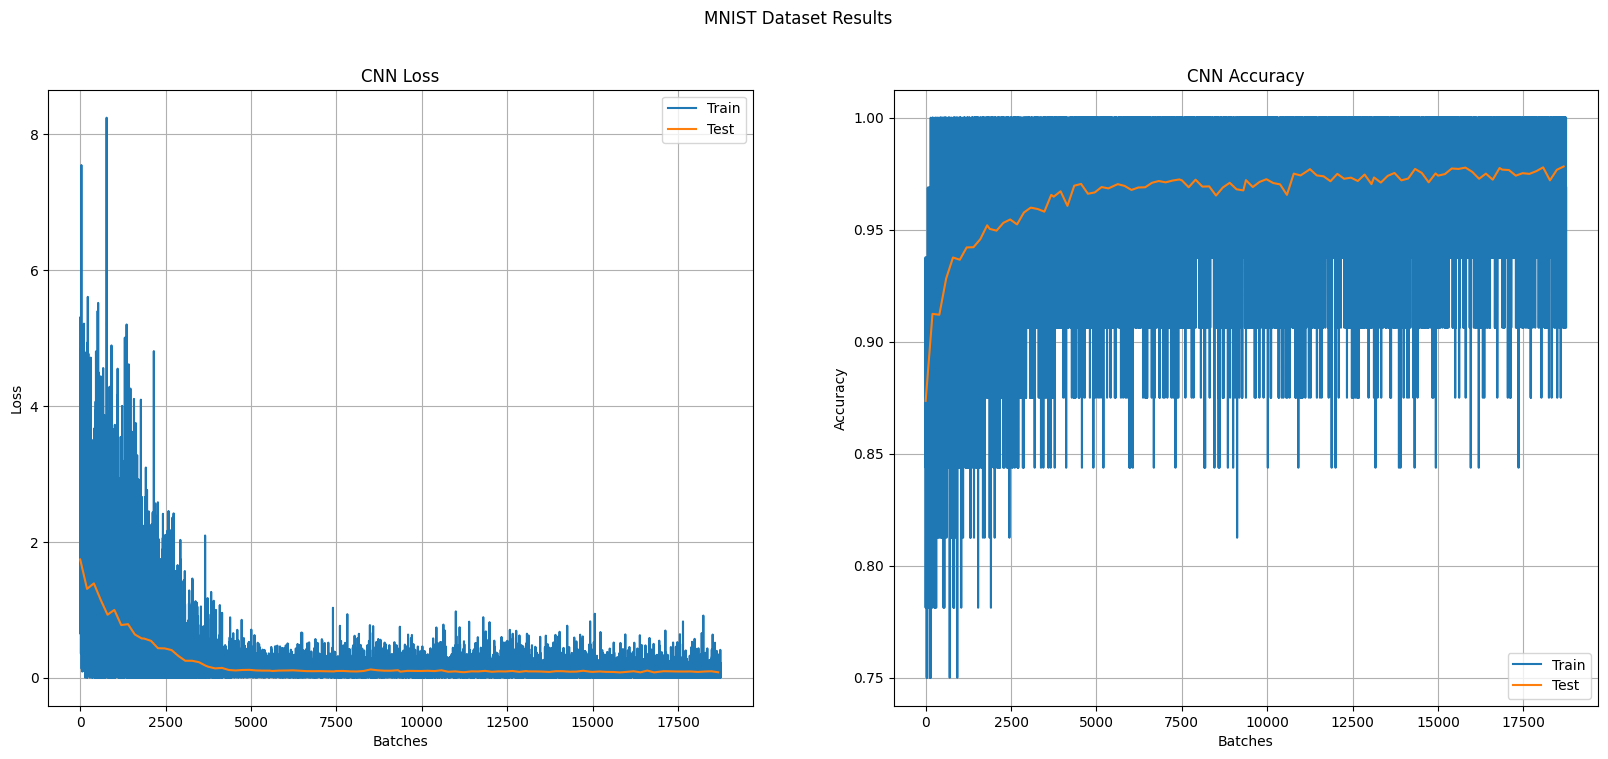

In [95]:
# View training results

# Plot info
plt.figure(figsize=(20,8))
plt.suptitle('MNIST Dataset Results')
x,y = zip(*validation_loss)
a,b = zip(*validation_accuracy)

# First subplot
plt.subplot(121)
plt.title('CNN Loss')
plt.plot(training_loss,label='Train')
plt.plot(x,y,label='Test')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Second subplot
plt.subplot(122)
plt.title('CNN Accuracy')
plt.plot(training_accuracy,label='Train')
plt.plot(a,b,label='Test')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [96]:
# Show top metrics
index, val = zip(*validation_accuracy)
idx,v = zip(*validation_loss)
print(f"Best Validation Accuracy: {np.round(np.array([i.item() for i in val]).max(),4)}")
print(f"Best Validation Loss: {np.round(np.array([i.item() for i in v]).max(),4)}")


Best Validation Accuracy: 0.9782
Best Validation Loss: 1.7404


In [97]:
# Model prediction on 6 random images
def digit_predictor():
    """
    Pulls 6 random images from the dataset and applys predicitons to them
    """

    # Create plot information
    fig, ax = plt.subplots(1, 6, figsize=(24,12))
    dataset_length = list(range(len(MNIST_DATA_TRAIN.data)))
    fig.suptitle('6 Random Images from MNIST Dataset', y=0.65, fontweight='bold')

    # Put Model in evaluation mode
    model.eval()

    # Iterate through each
    for i in range(6):
        random_image_index = np.random.choice(dataset_length)
        digit_prediction = model(MNIST_DATA_TRAIN.data[random_image_index].type(torch.float32).unsqueeze(0).unsqueeze(0).cuda()).argmax(1).item()
        ax[i].imshow(MNIST_DATA_TRAIN.data[random_image_index], cmap='gray')
        ax[i].set_title(f'(Actual: {MNIST_DATA_TRAIN.targets[random_image_index].item()})   (Prediction: {digit_prediction})')
    plt.show()

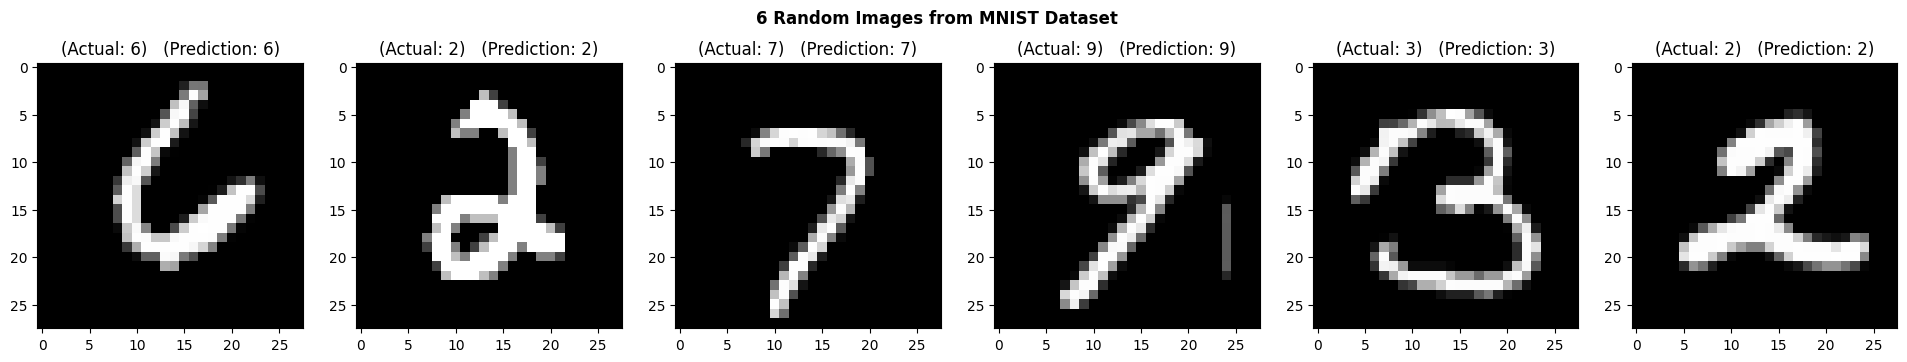

In [98]:
digit_predictor()